In [1]:
!mkdir -p ~/.kaggle

!cp kaggle.json /root/.kaggle/

import os
for filename in os.listdir('/content'):
    print(filename)

# Set the permissions for the kaggle.json file to make it readable only by the owner
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d hazemfahmy/openned-closed-eyes

!unzip openned-closed-eyes.zip

Streaming output truncated to the last 5000 lines.
  inflating: TestSet_json/TestSet_json/4419.json  
  inflating: TestSet_json/TestSet_json/44194.json  
  inflating: TestSet_json/TestSet_json/44195.json  
  inflating: TestSet_json/TestSet_json/44208.json  
  inflating: TestSet_json/TestSet_json/4424.json  
  inflating: TestSet_json/TestSet_json/44241.json  
  inflating: TestSet_json/TestSet_json/44246.json  
  inflating: TestSet_json/TestSet_json/4425.json  
  inflating: TestSet_json/TestSet_json/44271.json  
  inflating: TestSet_json/TestSet_json/44286.json  
  inflating: TestSet_json/TestSet_json/44294.json  
  inflating: TestSet_json/TestSet_json/4430.json  
  inflating: TestSet_json/TestSet_json/4431.json  
  inflating: TestSet_json/TestSet_json/44331.json  
  inflating: TestSet_json/TestSet_json/44340.json  
  inflating: TestSet_json/TestSet_json/44341.json  
  inflating: TestSet_json/TestSet_json/44354.json  
  inflating: TestSet_json/TestSet_json/44355.json  
  inflating: TestS

In [2]:
tpath = '/content/TrainingSet'
vpath = '/content/TestSet'

In [3]:
!pip install -q efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00


In [4]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
def show_images(folder_path, row, col, num_images=30):
    images = [f for f in os.listdir(folder_path) if f.lower().endswith('.jpg')]
    images_files = images[:num_images]

    fig, axes = plt.subplots(row, col, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        if i < len(images_files):
            image_path = os.path.join(folder_path, images[i])
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            ax.imshow(image)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

### Seeing the Data:

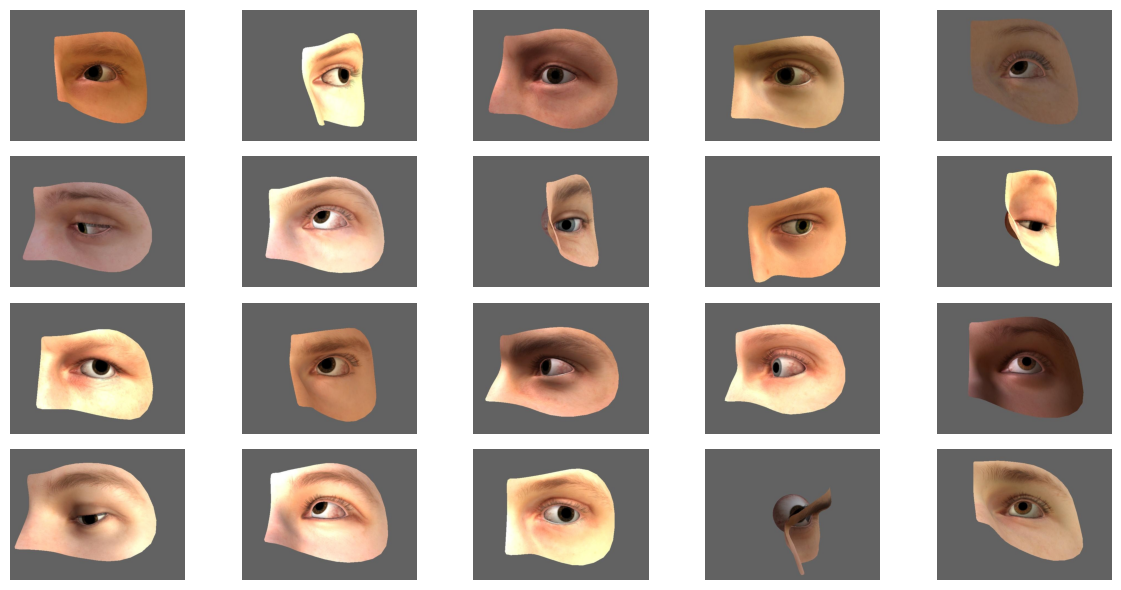

In [6]:
show_images('/content/TrainingSet/TrainingSet/Opened', 4,5)

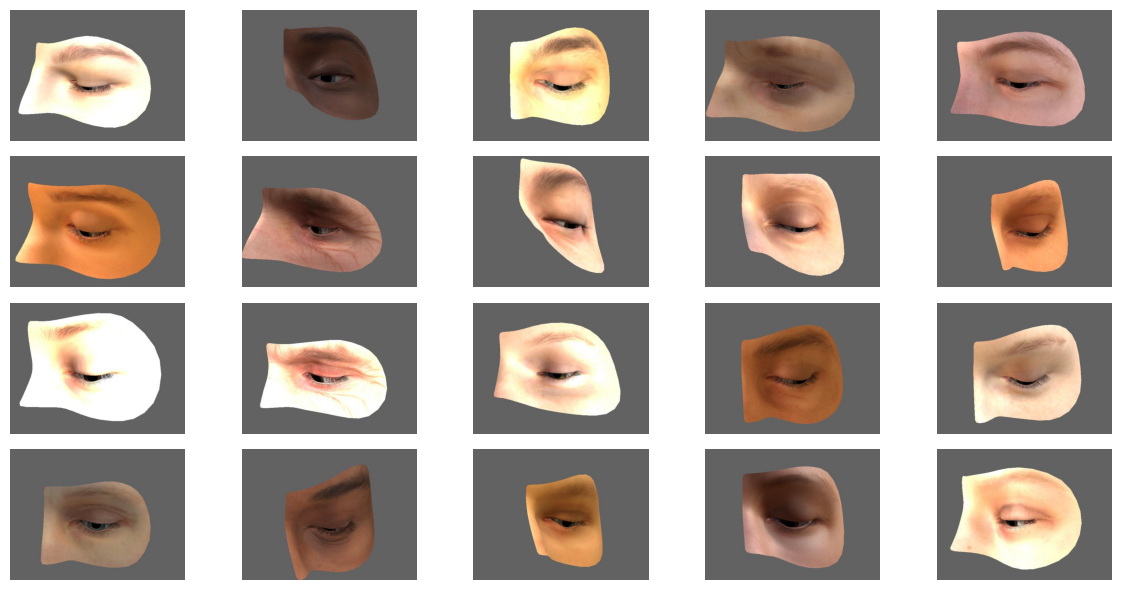

In [7]:
show_images('/content/TrainingSet/TrainingSet/Closed', 4,5)

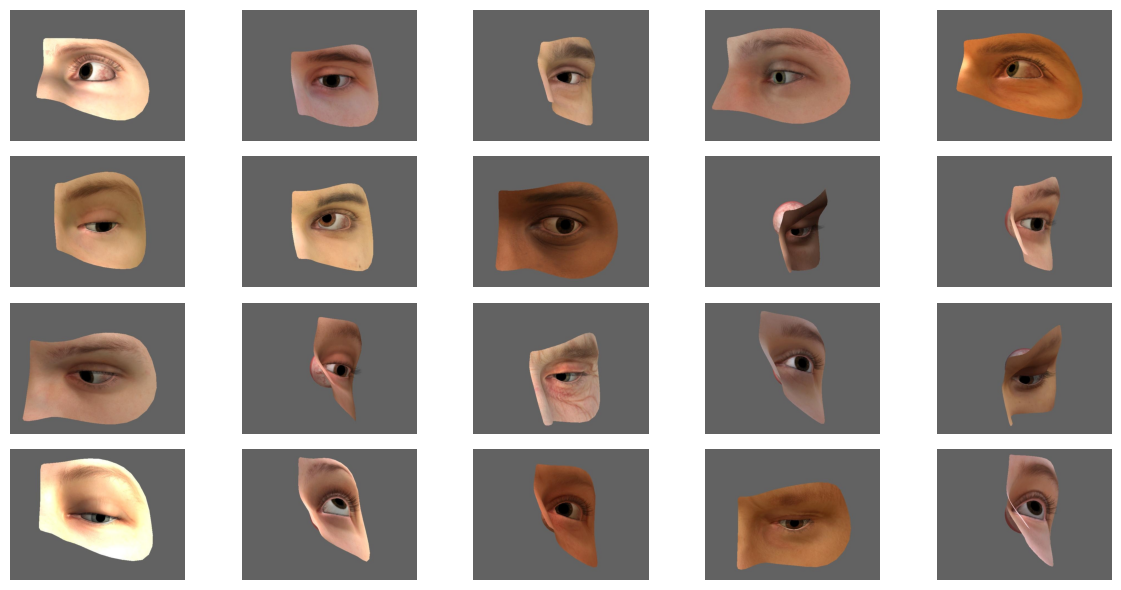

In [8]:
show_images('/content/TestSet/TestSet/Opened', 4,5)

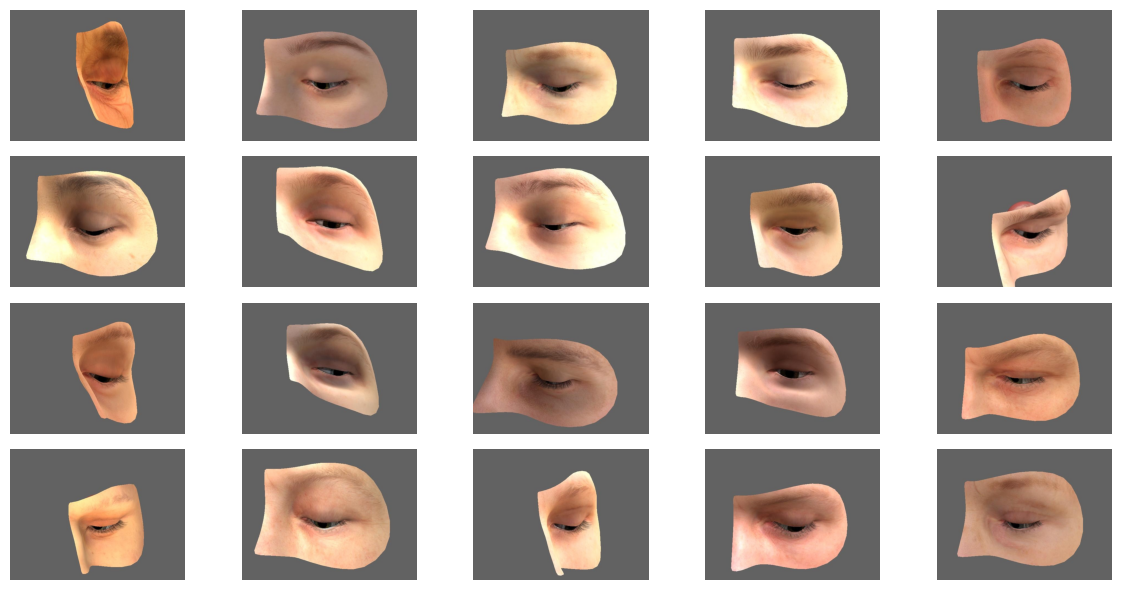

In [9]:
show_images('/content/TestSet/TestSet/Closed', 4,5)

In [10]:
training_data = image_dataset_from_directory(
    vpath,
    batch_size = 32,
    image_size = (227,227),
    shuffle = True,
    seed = 123,
    subset = 'training',
    validation_split = 0.01
)

validation_data = image_dataset_from_directory(
    tpath,
    batch_size = 32,
    image_size = (227,227),
    shuffle = True,
    seed = 123,
    validation_split = 0.99,
    subset = 'validation'
)

Found 4232 files belonging to 1 classes.
Using 4190 files for training.
Found 1704 files belonging to 1 classes.
Using 1686 files for validation.


## Modelling Time:

### 1. ResNet50:

In [14]:
resnet_model = Sequential()

pretrained_model = keras.applications.ResNet50(
    include_top = False,
    input_shape = (227, 227, 3),
    pooling = 'avg',
    classes = 2,
    weights = 'imagenet'
)
for layer in pretrained_model.layers:
  layer.trainable = False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(2, activation='softmax'))

In [15]:
resnet_model.compile(loss='sparse_categorical_crossentropy',
                     optimizer=keras.optimizers.SGD(learning_rate=0.0001),
                     metrics=['accuracy'])

In [16]:
epochs = 100
history = resnet_model.fit(
  training_data,
  validation_data = validation_data,
  epochs = epochs
)

Epoch 1/100
131/131 [==============================] - 34s 170ms/step - loss: 0.1895 - accuracy: 0.9327 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 2/100
131/131 [==============================] - 20s 148ms/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 1.0000
Epoch 3/100
131/131 [==============================] - 20s 148ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 4/100
131/131 [==============================] - 21s 156ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 5/100
131/131 [==============================] - 20s 149ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 6/100
131/131 [==============================] - 20s 149ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 7/100
131/131 [==============================] - 21s 155ms/step - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0044 -

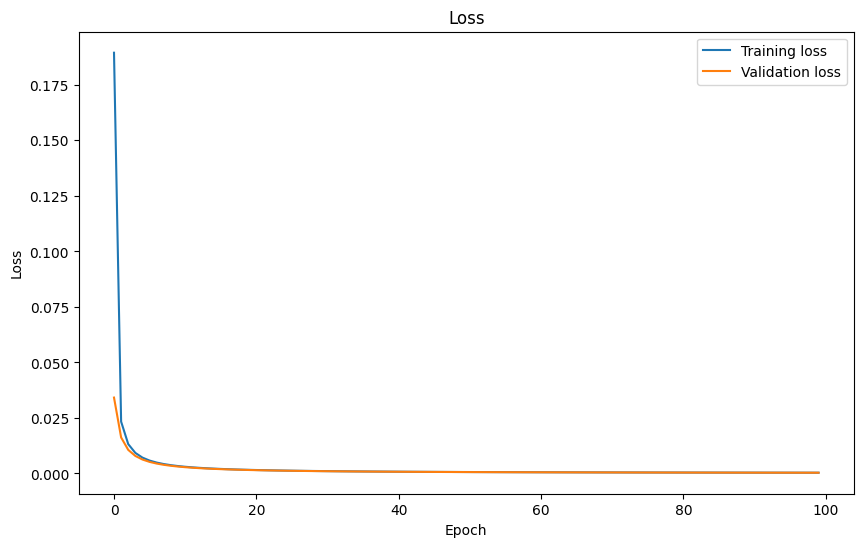

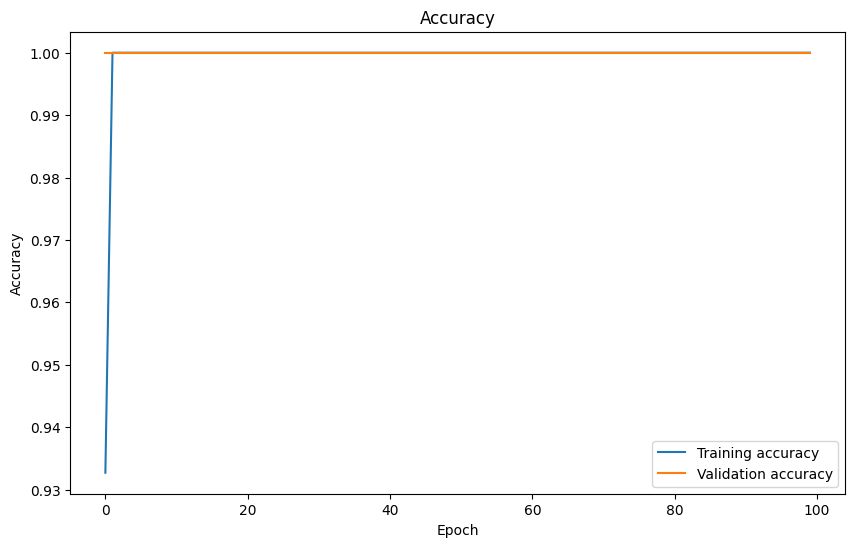

In [17]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [18]:
print(history.history['val_accuracy'][-1] * 100)

100.0
